In [18]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ;

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [20]:
path = '/kaggle/input/image250'

In [21]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned/train_cleaned'))
test_img = sorted(os.listdir(path + '/test/test'))
aug_img = sorted(os.listdir(path + '/aug-250/aug-250'))
aug_cleaned_img = sorted(os.listdir(path+'/aug_cleaned-250/aug_cleaned-250'))

In [22]:
print(len(train_img), len(train_cleaned_img), len(test_img), len(aug_img), len(aug_cleaned_img))

175 176 134 251 251


In [23]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [24]:
# prepare function
def process_image_r(img):
#     img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [25]:
def rotate_img(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
#     print(angle)
    
    if angle < -45:
        angle = -(90 + angle)
#         print("Less than -45", angle)
    else:
        angle = -angle
#         print("Greater than -45", angle)
        
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

In [26]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + '/train/train/')):
    filename = path + '/train/train/' + f
    if(filename.endswith('.png')==True or filename.endswith('.jpg')==True or filename.endswith('.jpeg')==True):
        train.append(process_image(filename))

for f in sorted(os.listdir(path + '/train_cleaned/train_cleaned')):
    filename = path + '/train_cleaned/train_cleaned/' + f
    if(filename.endswith('.png')==True or filename.endswith('.jpg')==True or filename.endswith('.jpeg')==True):
        train_cleaned.append(process_image(filename))
   
for f in sorted(os.listdir(path + '/test/test')):
    filename = path + '/test/test/' + f
    if(filename.endswith('.png')==True or filename.endswith('.jpg')==True or filename.endswith('.jpeg')==True):
        test.append(process_image(filename))
        
for f in sorted(os.listdir(path + '/aug-250/aug-250/')):
    filename = path + '/aug-250/aug-250/' + f
#     print(filename)
    if(filename.endswith('.png')==True or filename.endswith('.jpg')==True or filename.endswith('.jpeg')==True):
        image = cv2.imread(filename)
        rotated_img = rotate_img(image)
        train.append(process_image_r(rotated_img))
        
for f in sorted(os.listdir(path + '/aug_cleaned-250/aug_cleaned-250')):
    filename = path + '/aug_cleaned-250/aug_cleaned-250/' + f
    if(filename.endswith('.png')==True or filename.endswith('.jpg')==True or filename.endswith('.jpeg')==True):
        train_cleaned.append(process_image(filename))

In [27]:
print(len(train), len(train_cleaned),  len(test))
print(train[0].shape, train_cleaned[0].shape, test[0].shape)

426 426 133
(420, 540, 1) (420, 540, 1) (420, 540, 1)


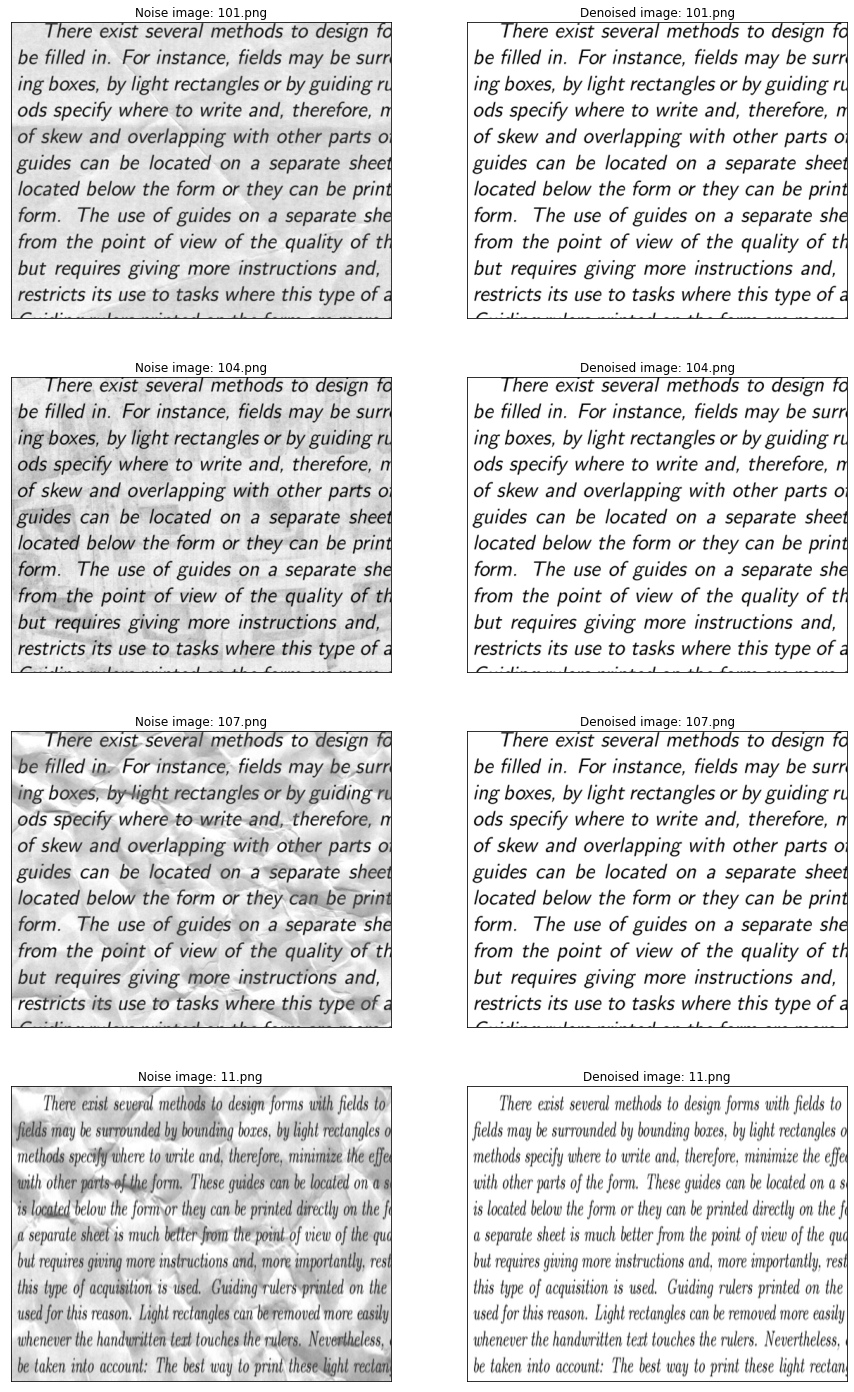

In [28]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [29]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [30]:
print('Training set shape: ', X_train.shape, Y_train.shape)
print('Validation set shape: ', X_val.shape, Y_val.shape)

Training set shape:  (362, 420, 540, 1) (362, 420, 540, 1)
Validation set shape:  (64, 420, 540, 1) (64, 420, 540, 1)


## Dropout=0.3 2 hidden layers adam optimizer

In [44]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.3)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

model = model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 210, 270, 128)     0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 210, 270, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 210, 270, 128)     1475

In [ ]:
callback = EarlyStopping(monitor='loss', patience=50, verbose=1)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=100, batch_size=4, verbose=1, callbacks=[callback])

Epoch 1/100
91/91 [==============================] - 12s 128ms/step - loss: 0.1417 - mae: 0.2847 - val_loss: 0.0655 - val_mae: 0.1687
Epoch 2/100
91/91 [==============================] - 11s 125ms/step - loss: 0.0585 - mae: 0.1692 - val_loss: 0.0698 - val_mae: 0.1301
Epoch 3/100
91/91 [==============================] - 11s 126ms/step - loss: 0.0506 - mae: 0.1400 - val_loss: 0.0686 - val_mae: 0.1306
Epoch 4/100
91/91 [==============================] - 11s 125ms/step - loss: 0.0471 - mae: 0.1294 - val_loss: 0.0631 - val_mae: 0.1422
Epoch 5/100
91/91 [==============================] - 11s 125ms/step - loss: 0.0456 - mae: 0.1265 - val_loss: 0.0587 - val_mae: 0.1364
Epoch 6/100
91/91 [==============================] - 11s 126ms/step - loss: 0.0483 - mae: 0.1301 - val_loss: 0.0542 - val_mae: 0.1311
Epoch 7/100
91/91 [==============================] - 11s 125ms/step - loss: 0.0490 - mae: 0.1306 - val_loss: 0.0521 - val_mae: 0.1443
Epoch 8/100
91/91 [==============================] - 11s 126ms

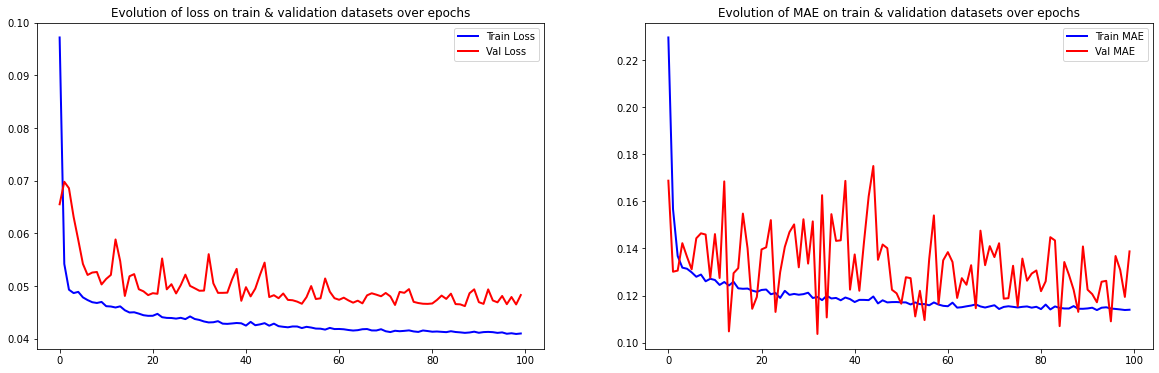

In [47]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [48]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

0
2
4
6


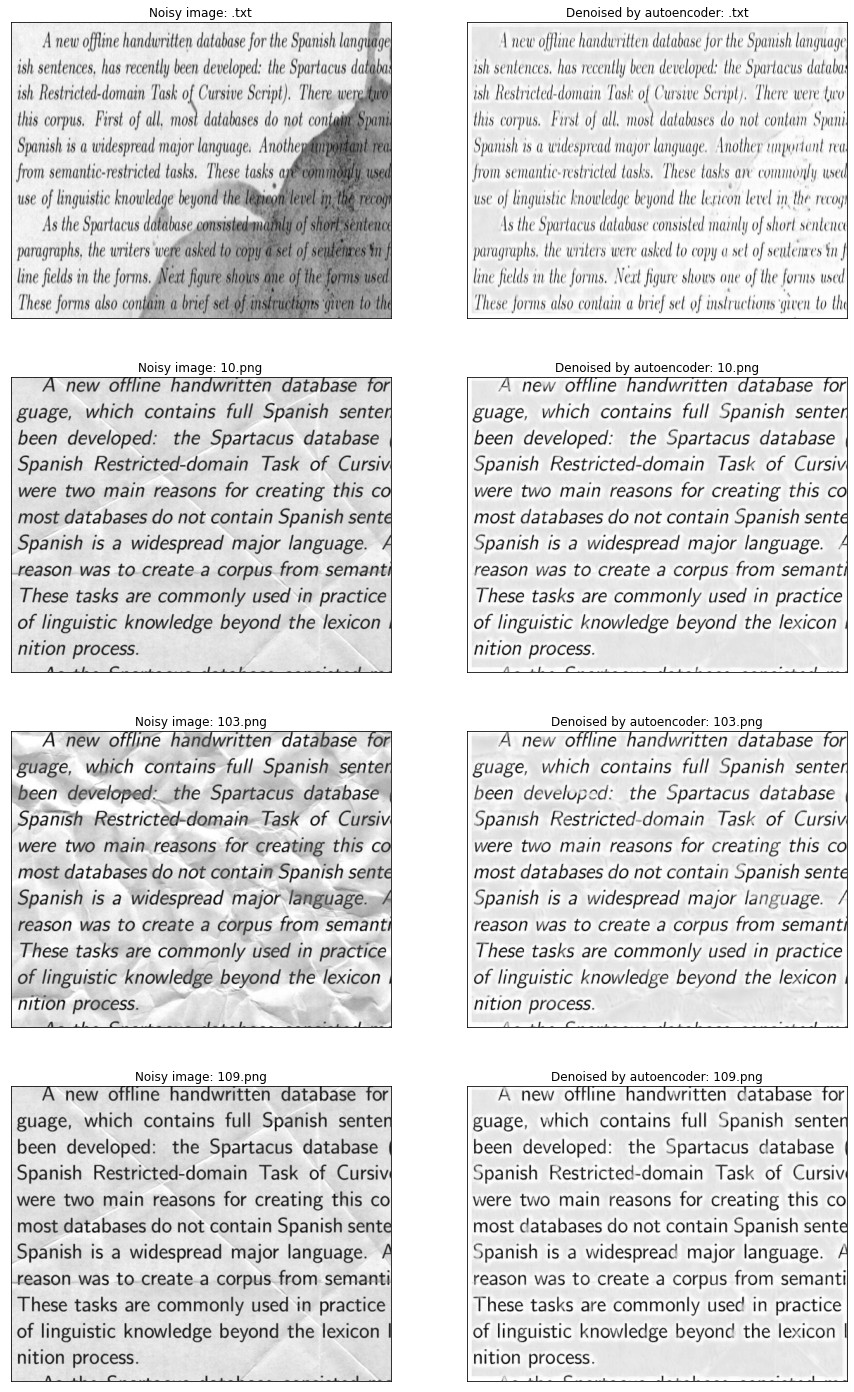

In [51]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
#     print(i)
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
model.save('denoise1-withaug250-tf')

In [ ]:
model.save('denoise1-withaug250-pickle.pkl')

## Change the optimizer and dropout to 0.5 along with 3 hidden layers
## 32, 64,128

In [ ]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3,3), activation = 'relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='RMSProp' , loss='mean_squared_error', metrics=['mae'])

    return model

model = model()
model.summary()

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    print(i)
    plt.imshow(X_test[104][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[104][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()